This file applies built-in MHA, no mask, non normalize Y

# HEPERS

In [1]:
import numpy as np
import pickle
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd 
from collections import defaultdict
import random
import seaborn as sns

def load_files_from_folders(folders, max_files):
    file_list = []
    for folder in folders:
        for i in range(max_files):
            file = ''.join([folder,str(f'/5by5_Data{i}')])
            file_list.append(file)
    return file_list

def read_file(filename):
  with open(filename, "rb") as file:
      stat = pickle.load(file)
      file.close()
  return stat

def split_dataset(files, train_ratio, val_ratio):
    random.shuffle(files)
    
    total_files = len(files)
    train_size = int(total_files * train_ratio)
    val_size = int(total_files * val_ratio)
    
    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    return train_files, val_files, test_files

# Need to load all files in dataset to get unique path dict
def path_encoder(files):
    path_sample = []
    for file_name in files:
        stat = read_file(file_name)
        path_sample.append(stat["data"]["paths_link"])

    all_path_link = [path_sample[i].values() for i in range(len(path_sample))]
    unique_values_set = {tuple(p) for path_set in all_path_link for path in path_set for p in path}
    path_set_dict = {v: k for k, v in enumerate(unique_values_set, start=1)}
    return path_set_dict

def create_matrix(data, nodes):
    # data is an array, nodes is a set
    matrix = np.zeros((len(nodes), len(nodes)))
    for (o, d), v in data:
        o = int(o)
        d = int(d)
        matrix[o-1][d-1] = v
    matrix = matrix.reshape(-1, 1).astype(float) # 625x1
    return matrix

def get_graphMatrix(network, nodes):
    # 625x3
    cap = np.array(network[['init_node', 'term_node', 'capacity']].apply(lambda row: ((row['init_node'], row['term_node']), row['capacity']), axis=1).tolist(), dtype=object)
    length = np.array(network[['init_node', 'term_node', 'length']].apply(lambda row: ((row['init_node'], row['term_node']), row['length']), axis=1).tolist(), dtype=object)
    fft = np.array(network[['init_node', 'term_node', 'free_flow_time']].apply(lambda row: ((row['init_node'], row['term_node']), row['free_flow_time']), axis=1).tolist(), dtype=object)

    # Cap = create_matrix(cap, nodes)
    Length = create_matrix(length, nodes)
    Fft = create_matrix(fft, nodes)

    # matrix = np.concatenate((normalize(Cap), np.log1p(Length), np.log1p(Fft)), axis=1)
    matrix = np.concatenate((np.log1p(Length), np.log1p(Fft)), axis=1)
    return matrix

def get_demandMatrix(demand, nodes):
    # 625x1
    tensor = np.array([(key, value) for key, value in demand.items()], dtype=object)
    tensor = create_matrix(tensor, nodes)
    return tensor

# Get 3 feasible paths for each OD pair, return tensor shape 625x3
def get_pathMatrix(path_links, nodes, unique_set):
    # 625x3
    paths = np.array([(key, [tuple(path) for path in value]) for key, value in path_links.items()], dtype=object)
    p1, p2, p3 = [], [], []
    for od, path_list in paths:
        path1 = path2 = path3 = 0
        
        if len(path_list) > 0:
            path1 = path_list[0]
        if len(path_list) > 1:
            path2 = path_list[1]
        if len(path_list) > 2:
            path3 = path_list[2]
        
        p1.append((od, unique_set[path1] if path1 != 0 else 0))
        p2.append((od, unique_set[path2] if path2 != 0 else 0))
        p3.append((od, unique_set[path3] if path3 != 0 else 0))
    p1 = create_matrix(p1, nodes)
    p2 = create_matrix(p2, nodes)
    p3 = create_matrix(p3, nodes)
    matrix = np.concatenate((p1, p2, p3), axis=1)
    return matrix

# Get path flow distribution (Y), return a tensor 625x3
def get_flowMatrix(demand, path_flows, nodes):
    # 625x3
    flows = np.array([(k, v) for k, v in zip(demand.keys(), path_flows)], dtype=object)
    p1, p2, p3 = [], [], []
    for od, flow in flows:
        path1 = path2 = path3 = 0
        if len(flow) > 0:
            path1 = flow[0]
        if len(flow) > 1:
            path2 = flow[1]
        if len(flow) > 2:
            path3 = flow[2]
        
        p1.append((od, path1 if path1 != 0 else 0))
        p2.append((od, path2 if path2 != 0 else 0))
        p3.append((od, path3 if path3 != 0 else 0))
    p1 = create_matrix(p1, nodes)
    p2 = create_matrix(p2, nodes)
    p3 = create_matrix(p3, nodes)

    matrix = np.concatenate((p1, p2, p3), axis=1)
    return matrix

def get_frequency(path_link):
    a = tuple(tuple(p) for path in path_link.values() for p in path)
    frequency_dict = {}
    for sublist in a:
        for value in sublist:
            if value in frequency_dict:
                frequency_dict[value] += 1
            else:
                frequency_dict[value] = 1
    frequency_dict = dict(sorted(frequency_dict.items()))
    return frequency_dict

def map_frequence(row, frequency_dict):
    if row in frequency_dict.keys():
        return frequency_dict[row]
    return 0

def get_frequenceMatrix(path_link, net, nodes):
    frequency_dict = get_frequency(path_link)
    net['frequence'] = net['link_id'].apply(lambda x: map_frequence(x, frequency_dict))
    frequence = np.array(net[['init_node', 'term_node', 'frequence']].apply(lambda row: ((row['init_node'], row['term_node']), row['frequence']), axis=1).tolist(), dtype=object)
    frequence = create_matrix(frequence, nodes)
    return frequence

def create_mask(matrix):
    tensor = tf.convert_to_tensor(matrix, dtype=tf.float32)
    mask = tf.expand_dims(tf.sign(tf.reduce_sum(tf.abs(tensor), axis=-1)),-1) # create mask for row
    return mask

def to_percentage_list(lst):
    total = sum(lst)
    if total == 0:
        return [0.0, 0.0, 0.0]
    return [x / total for x in lst]

def normalize(tensor):
    scaler = MinMaxScaler()
    normed = scaler.fit_transform(tensor)
    return normed

def normalizeY(tensor):
    scaler = MinMaxScaler()
    normed = scaler.fit_transform(tensor)
    return normed, scaler

# def normalizeY(tensor):
#     if not isinstance(tensor, np.ndarray):
#         tensor = np.array(tensor)
#     scaler = MinMaxScaler()
#     normed = scaler.fit_transform(np.transpose(tensor))
#     tensor = np.transpose(normed)
#     tensor = tensor[:, :-1]
#     return tensor, scaler

# No mask model
def generate_xy(file_name, unique_set, test_set=None):
    with open(file_name, "rb") as file:
        stat = pickle.load(file)
        file.close()

    path_links = stat["data"]["paths_link"]
    demand = stat["data"]["demand"]
    path_flows = stat["path_flow"]
    path_flows = [to_percentage_list(inner_list) for inner_list in path_flows]
    nodes = stat["data"]["nodes"]
    net = stat["data"]["network"]

    # Get X
    Graph = get_graphMatrix(net, nodes) #return normalized data
    OD_demand = get_demandMatrix(demand, nodes)
    Path_tensor = get_pathMatrix(path_links, nodes, unique_set)
    # Frequence = get_frequenceMatrix(path_links, net, nodes)

    # X = np.concatenate((Graph, normalize(OD_demand), normalize(Path_tensor), normalize(Frequence)), axis=1)
    X = np.concatenate((Graph, normalize(OD_demand), normalize(Path_tensor)), axis=1)
    # X = normalize(X)
    X = tf.convert_to_tensor(X, dtype=tf.float32) # 625x8    
    
    # Get Y
    Y = get_flowMatrix(demand, path_flows, nodes)
    # Y = np.concatenate((Y, OD_demand), axis=1)
    # Y, scaler = normalizeY(Y)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)   
    
    # if test_set:
    #     return X, Y, scaler
    return X, Y

# PARAMETERS

In [7]:
# %run tf_helpers.py

DATA_SIZE = 4000
FOLDERS = ['SiouxFalls/Output2'] # remove 5% links
TRAIN_RATE = 0.7
VAL_RATE = 0.2
TEST_RATE = 0.1
BATCH_SIZE = 64

# TRAINING 
device = 'gpu'
input_dim = 6
output_dim = 3
d_model = 128
heads=8
E_layer = 8
D_layer = 2
epochs = 400
learning_rate = 0.001
dropout=0.1
l2_reg=1e-6

# TRANSFORMER

In [3]:
import tensorflow as tf
from keras import layers as tfl
from keras import regularizers, Sequential
from tqdm.notebook import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.activations import sigmoid, linear, softmax

class EncoderLayer(tfl.Layer):
    def __init__(self, input_dim, d_model, heads, dropout, l2_reg):
        super().__init__()
        self.attn_layer = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm1 = tfl.LayerNormalization(epsilon=1e-6)
        # leaky_relu = LeakyReLU(alpha=0.3)
        self.ffn = Sequential([
            tfl.Dense(d_model, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            tfl.Dropout(dropout),
            tfl.Dense(input_dim, kernel_regularizer=regularizers.l2(l2_reg))
        ])
        self.dropout = tfl.Dropout(dropout)
        self.layer_norm2 = tfl.LayerNormalization(epsilon=1e-6)

    def call(self, x, training=None):
        attn_output = self.attn_layer(query=x, key=x, value=x)
        x = self.layer_norm1(x + self.dropout(attn_output))
        x = self.layer_norm1(self.dropout(x))

        ffn_output = self.ffn(x, training=training)
        x = self.layer_norm2(x + ffn_output)
        x = self.layer_norm2(self.dropout(x))
        return x

class Encoder(tfl.Layer):
    def __init__(self, input_dim, d_model, N, heads, dropout, l2_reg):
        super().__init__()
        self.layers = [EncoderLayer(input_dim, d_model, heads, dropout, l2_reg) for _ in range(N)]
        self.dense = tfl.Dense(3, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    def call(self, x):
        output = x
        for layer in self.layers:
            output = layer(output)
        return self.dense(output)

class DecoderLayer(tfl.Layer):
    def __init__(self, output_dim, d_model, heads, dropout, l2_reg):
        super().__init__()
        self.mha1 = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm1 = tfl.LayerNormalization(epsilon=1e-6)
        self.mha2 = tfl.MultiHeadAttention(num_heads=heads, key_dim=d_model // heads, attention_axes=2)
        self.layer_norm2 = tfl.LayerNormalization(epsilon=1e-6)
        # leaky_relu = LeakyReLU(alpha=0.3)
        self.ffn = Sequential([
            tfl.Dense(d_model, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
            tfl.Dropout(dropout),
            tfl.Dense(output_dim, kernel_regularizer=regularizers.l2(l2_reg))
        ])
        self.layer_norm3 = tfl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfl.Dropout(dropout)
        self.dropout2 = tfl.Dropout(dropout)
        self.dropout3 = tfl.Dropout(dropout)

    def call(self, x, encoder_output, training=None):
        attn1 = self.mha1(query=x, key=x, value=x, training=training)
        x = self.layer_norm1(x + self.dropout1(attn1))
        # x = self.layer_norm3(self.dropout3(x)) # ignore this layer, loss 0.0022 in 150 epochs

        attn2 = self.mha2(query=x, key=encoder_output, value=encoder_output, training=training)
        x = self.layer_norm2(x + self.dropout2(attn2))
        x = self.layer_norm3(self.dropout3(x))

        ffn_output = self.ffn(x, training=training)
        x = self.layer_norm3(x + ffn_output)
        x = self.layer_norm3(self.dropout3(x))
        return x

class Decoder(tfl.Layer):
    def __init__(self, output_dim, d_model, N, heads, dropout, l2_reg):
        super().__init__()
        self.layers = [DecoderLayer(output_dim, d_model, heads, dropout, l2_reg) for _ in range(N)]

    def call(self, x, encoder_output, training=None):
        output = x
        for layer in self.layers:
            output = layer(output, encoder_output, training=training)
        return output

class Transformer(tf.keras.Model):
    def __init__(self, input_dim, output_dim, d_model, E_layer, D_layer, heads, dropout, l2_reg):
        super().__init__()
        self.encoder = Encoder(input_dim, d_model, E_layer, heads, dropout, l2_reg)
        self.decoder = Decoder(output_dim, d_model, D_layer, heads, dropout, l2_reg)
        self.activation = Activation('sigmoid')

    def call(self, x, y, training=None):
        encoder_output = self.encoder(x, training=training)
        decoder_output = self.decoder(y, encoder_output, training=training)
        decoder_output = self.activation(decoder_output)
        return decoder_output

    def eval(self):
        for layer in self.encoder.layers:
            layer.trainable = False
        for layer in self.decoder.layers:
            layer.trainable = False

    def train(self):
        for layer in self.encoder.layers:
            layer.trainable = True
        for layer in self.decoder.layers:
            layer.trainable = True

    def fit(self, train_data_loader, val_data_loader, optimizer, loss_fn, epochs, device):
        # Define the early stopping callback
        early_stopping = EarlyStopping(
            monitor='val_loss',
            patience=5,
            verbose=1,
            mode='min',
            restore_best_weights=True
        )

        reduce_lr = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.0001,
            verbose=1
        )

        train_losses = []
        val_losses = []

        src, trg = next(iter(train_data_loader))
        self(src, trg, training=True)

        self.compile(optimizer=optimizer, loss=loss_fn)

        with tqdm(total=epochs, unit="epoch") as pbar:
            for epoch in range(epochs):
                # Training phase
                self.train()
                total_train_loss = 0
                for src, trg in train_data_loader:
                    with tf.device(device):
                        with tf.GradientTape() as tape:
                            output = self.call(src, trg)
                            loss = loss_fn(trg, output)

                        # Backpropagate and update the model
                        gradients = tape.gradient(loss, self.trainable_variables)
                        optimizer.apply_gradients(zip(gradients, self.trainable_variables))
                        total_train_loss += loss.numpy()
                        pbar.set_description(f"Train Loss: {total_train_loss / len(train_data_loader):.4f}")

                # Validation phase
                self.eval()
                total_val_loss = 0
                for src, trg in val_data_loader:
                    with tf.device(device):
                        output = self.call(src, trg)
                        loss = loss_fn(trg, output)
                        total_val_loss += loss.numpy()

                        pbar.set_description(f"Val Loss: {total_val_loss / len(val_data_loader):.4f}")

                pbar.update(1)
                train_losses.append(total_train_loss / len(train_data_loader))
                val_losses.append(total_val_loss / len(val_data_loader))
                print(f"Epoch: {epoch+1} - Train Loss: {total_train_loss/len(train_data_loader):.4f}, Val Loss: {total_val_loss/len(val_data_loader):.4f}")

                # Check for early stopping
                if early_stopping.model is not None:
                    early_stopping.on_epoch_end(epoch, {'val_loss': total_val_loss / len(val_data_loader)})
                    reduce_lr.on_epoch_end(epoch, {'val_loss': total_val_loss / len(val_data_loader)})
                    if early_stopping.stopped_epoch > 0:
                        print(f"Early stopping triggered at epoch {early_stopping.stopped_epoch + 1}")
                        break
        return self, train_losses, val_losses
    
    def predict(self, x):
        encoder_output = self.encoder(x, training=False)
        decoder_input = tf.zeros((tf.shape(x)[0], tf.shape(x)[1], 3))
        predictions = self.decoder(decoder_input, encoder_output, training=False)
        predictions = self.activation(predictions)
        return predictions

# CREATE DATASET

In [4]:
files = load_files_from_folders(FOLDERS, max_files=100)
path_set_dict = path_encoder(files)
print("Path set number: ", len(path_set_dict))

class Dataset:
    def __init__(self, files):
        # self.path_encoded = path_encoder()  # Get path encode dictionary
        self.X = []
        self.Y = []

        for file_name in tqdm(files):
            x, y = generate_xy(file_name, path_set_dict)
            self.X.append(x)
            self.Y.append(y)

        self.X = tf.stack(self.X, axis=0)
        self.Y = tf.stack(self.Y, axis=0)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def to_tf_dataset(self, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.Y))
        dataset = dataset.shuffle(buffer_size=len(self.X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

def get_test_set(files):
    X = []
    Y = []
    Scalers = []
    for file_name in tqdm(files) :
        x, y, scaler = generate_xy(file_name, path_set_dict, test_set=True)
        X.append(x)
        Y.append(y)
        Scalers.append(scaler)

    X = tf.stack(X, axis=0)
    Y = tf.stack(Y, axis=0)
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return dataset, Scalers

Path set number:  1654


In [5]:
files = load_files_from_folders(FOLDERS, max_files=DATA_SIZE)
train_files, val_files, test_files = split_dataset(files, TRAIN_RATE, VAL_RATE)

train_dataset = Dataset(train_files)
train_data_loader = train_dataset.to_tf_dataset(BATCH_SIZE)

val_dataset = Dataset(val_files)
val_data_loader = train_dataset.to_tf_dataset(BATCH_SIZE)

test_dataset = Dataset(test_files)
test_data_loader = test_dataset.to_tf_dataset(BATCH_SIZE)
# test_data_loader, scalers = get_test_set(test_files)

  0%|          | 0/2800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

# TRAIN MODEL

In [8]:
from tensorflow.keras.optimizers import Adam  
from tensorflow.keras.losses import MeanSquaredError
import time
# %run tf_attention_noMask.py

# percentage normalize Y, sigmoid
# difference normalize for X, remove link cap, frequency
model = Transformer(input_dim=input_dim, output_dim=output_dim,
                    d_model=d_model, E_layer=E_layer, D_layer=D_layer,
                    heads=heads, dropout=dropout, l2_reg=l2_reg)
loss_fn = MeanSquaredError()
optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0, decay=l2_reg)

start = time.time()
model, train_loss, val_loss = model.fit(train_data_loader, val_data_loader, optimizer, loss_fn, epochs, device)
end = time.time()
train_time = end-start

  0%|          | 0/400 [00:00<?, ?epoch/s]

Epoch: 1 - Train Loss: 0.1609, Val Loss: 0.1563
Epoch: 2 - Train Loss: 0.1519, Val Loss: 0.1475
Epoch: 3 - Train Loss: 0.1434, Val Loss: 0.1391
Epoch: 4 - Train Loss: 0.1352, Val Loss: 0.1312
Epoch: 5 - Train Loss: 0.1274, Val Loss: 0.1235
Epoch: 6 - Train Loss: 0.1199, Val Loss: 0.1163
Epoch: 7 - Train Loss: 0.1129, Val Loss: 0.1094
Epoch: 8 - Train Loss: 0.1062, Val Loss: 0.1029
Epoch: 9 - Train Loss: 0.0999, Val Loss: 0.0969
Epoch: 10 - Train Loss: 0.0941, Val Loss: 0.0913
Epoch: 11 - Train Loss: 0.0887, Val Loss: 0.0861
Epoch: 12 - Train Loss: 0.0838, Val Loss: 0.0814
Epoch: 13 - Train Loss: 0.0792, Val Loss: 0.0771
Epoch: 14 - Train Loss: 0.0751, Val Loss: 0.0732
Epoch: 15 - Train Loss: 0.0714, Val Loss: 0.0696
Epoch: 16 - Train Loss: 0.0680, Val Loss: 0.0664
Epoch: 17 - Train Loss: 0.0650, Val Loss: 0.0635
Epoch: 18 - Train Loss: 0.0622, Val Loss: 0.0609
Epoch: 19 - Train Loss: 0.0598, Val Loss: 0.0586
Epoch: 20 - Train Loss: 0.0575, Val Loss: 0.0564
Epoch: 21 - Train Loss: 0.055

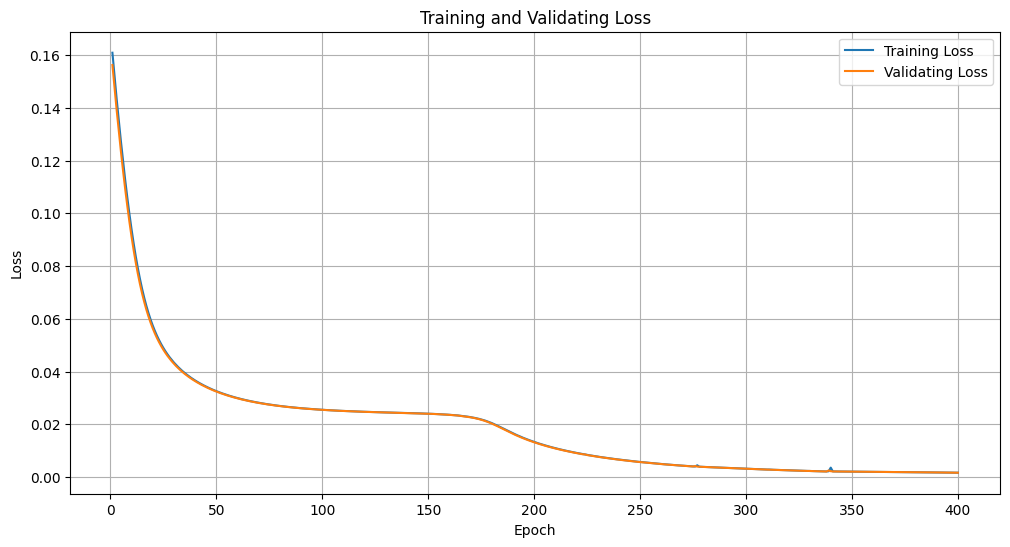

In [10]:
%run plotting.py
plot_loss(train_loss, val_loss, epochs)

# CHECK DELAY OF PREDICTED VALUES

In [11]:
def inversed(normed, scaler):
    # normed: 625x3
    tensor = scaler.inverse_transform(np.transpose(normed))
    tensor = np.transpose(tensor)
    return tensor

def predict_withScaler(model, test_data_loader, scalers, device):
    model.eval()
    predicted_values = []
    scaler_idx = 0
    for src, trg in test_data_loader:
        with tf.device(device):
            # output = model.predict(src, src_mask, tgt_mask)
            output = model.call(src, trg)
            for i in range(len(src)):
                scaler = scalers[scaler_idx]
                scaler_idx +=1
                pred_matrix = inversed(output[i].numpy(), scaler)
                predicted_values.append(pred_matrix)

    return predicted_values

def predict_percentage(model, test_data_loader, device):
    model.eval()
    predicted_values = []
    for src, trg in test_data_loader:
        with tf.device(device):
            output = model.call(src, trg)
            for i in range(len(src)):
                predicted_values.append(output[i].numpy())

    return predicted_values

# pred_tensor = predict_withScaler(model, test_data_loader, scalers, device)
pred_tensor = predict_percentage(model, test_data_loader, device)

In [ ]:
%run tf_helpers.py
import pandas as pd
import numpy as np

i = 2
file_name = test_files[i]
stat = read_file(file_name)
demand = stat["data"]["demand"]
pred_df, _, _, _ = create_pred_df(pred_tensor[i], stat)

# Predicted link and path flow
pred_link_flow = sum_pred_link_flow(pred_df, stat)
pred_df, pred_avg_delay = calculate_delay(pred_df, pred_link_flow)

# Solution link and path flow
UE_link, path_link_df, avg_path_cost = mean_path_cost(stat)

[link_flow, path_flow],delays, lens, _, _ = single_avg_delay(pred_tensor[i], file_name)

  0%|          | 0/400 [00:00<?, ?it/s]

Avg path cost:  127.1982 mins
Prediction average delay:  21.5058 mins =  16.91 %
Solution average delay:  0.0665 mins
Difference: 21.4393 mins


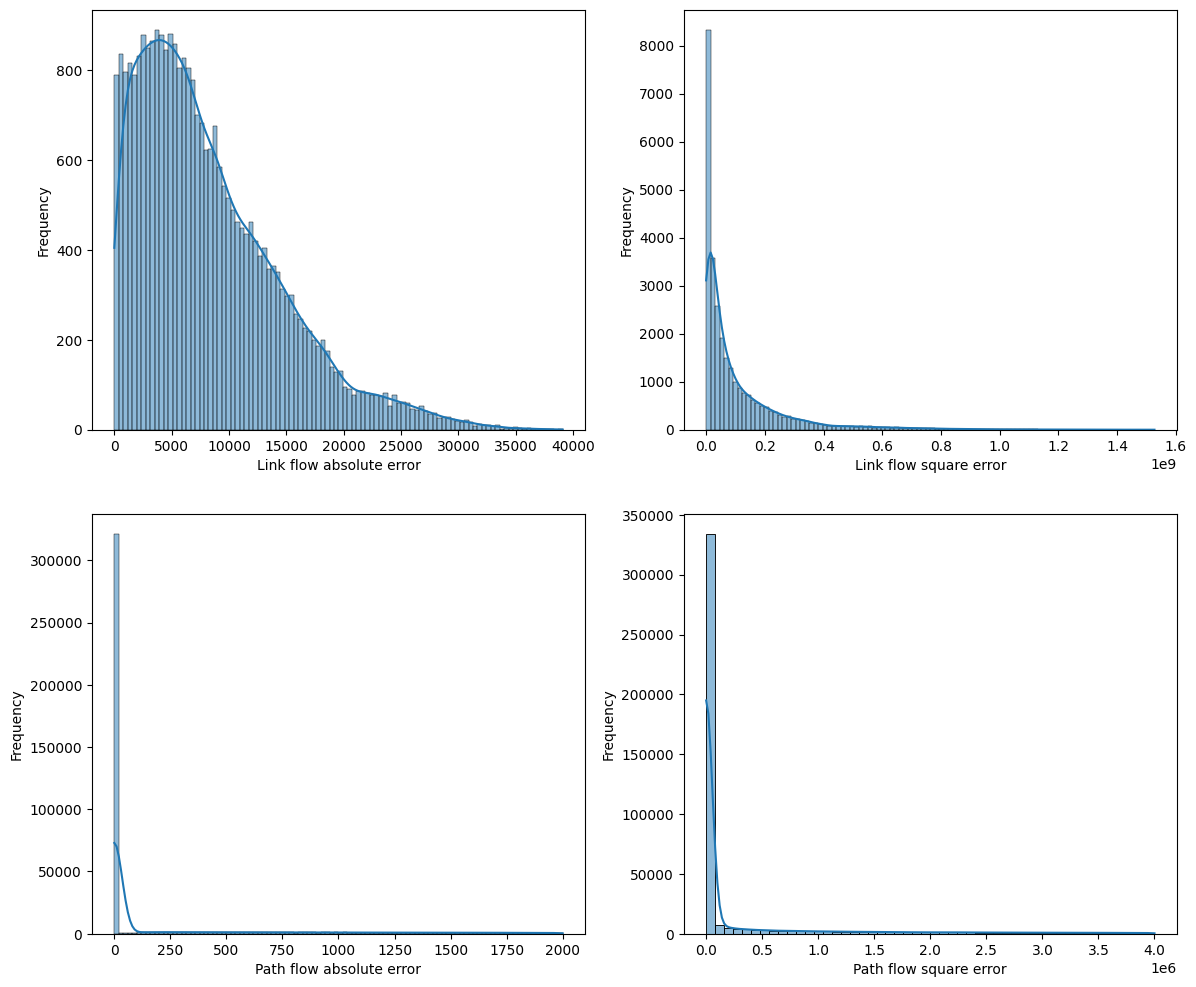

In [12]:
import numpy as np
%run tf_helpers.py
%run plotting.py

size = len(test_files)

Avg_delay, Solution_avg_delay, Len_origin, Len_pred, Nan_num, Avg_path_cost = [], [], [], [], [], []
Link_flow, Path_flow = [], []
for i, filename in tqdm(zip(pred_tensor[:size], test_files[:size]), total=size):
    flows, delays, lens, nan_num, avg_path_cost = single_avg_delay(i, filename)

    Avg_delay.append(delays[0])
    Solution_avg_delay.append(delays[1])
    Len_pred.append(lens[0])
    Len_origin.append(lens[1])
    Nan_num.append(nan_num)
    Avg_path_cost.append(avg_path_cost)
    Link_flow.append(flows[0])
    Path_flow.append(flows[1])

df = pd.DataFrame({
    'origin_od_pair': Len_origin,
    'pred_od_pair': Len_pred,
    'nan_percentage': Nan_num,
    'Pred_ad': Avg_delay,
    'Solution_ad': Solution_avg_delay
})
df.to_csv("predicted_result.csv")
p = np.mean(Avg_delay)
s = np.mean(Solution_avg_delay)
print("Avg path cost: ", round(np.mean(Avg_path_cost), 4), "mins")
print("Prediction average delay: ", round(p,4), "mins = ", round(p/np.mean(Avg_path_cost)*100, 2), "%")
print("Solution average delay: ", round(s, 4), "mins")
print(f"Difference: {round(p-s,4)} mins")

plot_error(Link_flow, Path_flow)

In [13]:
%run tf_helpers.py

link_indicator = calculate_indicator(Link_flow)
path_indicator = calculate_indicator(Path_flow)
rows = ['MAE', 'RMSE', 'MAPE']
result = pd.DataFrame({'Indicator': rows, 
                       'Link flow': link_indicator, 
                       'Path flow': path_indicator})
print(result)
Link_mae_df = heatmap_link_mae(Link_flow, test_files[0], 10)

,Indicator,Link flow,Path flow
0,MAE,8293.616644,208.418675
1,RMSE,10431.579986,512.164320
2,MAPE,50.634617,73.860048


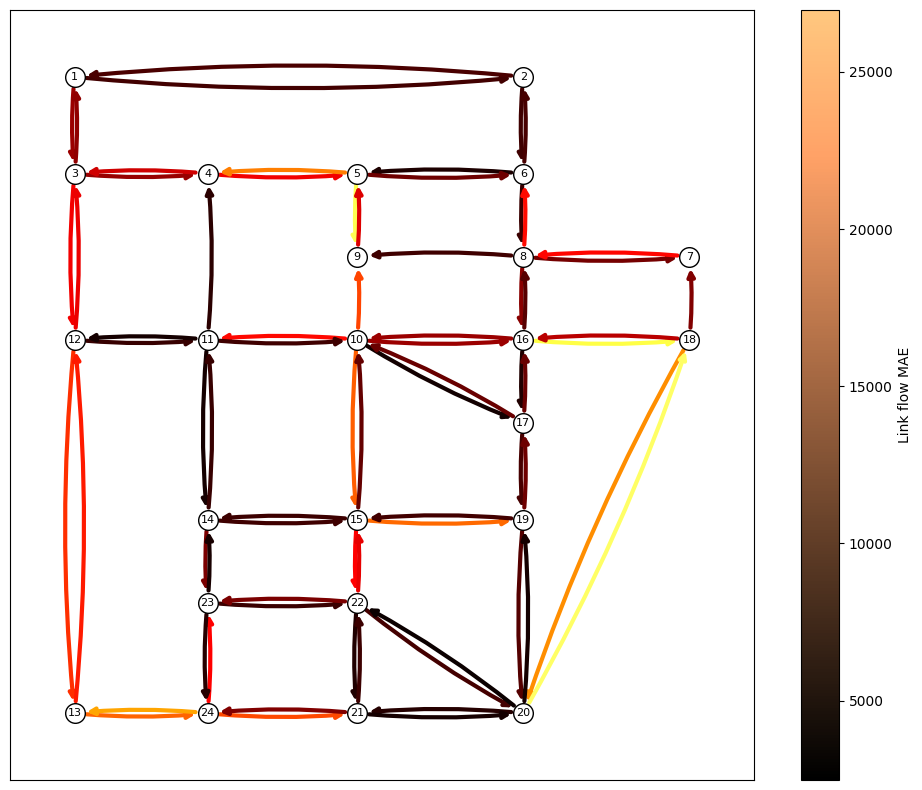

In [14]:
%run tf_helpers.py
Link_mae_df = heatmap_link_mae(Link_flow, test_files[0], 10)

In [83]:
print(Link_mae_df[Link_mae_df['link_mae'] == max(Link_mae_df['link_mae'])])
Link_mae_df['link_mae'][Link_mae_df['link_mae'] >12000] = Link_mae_df['link_mae']-5000
Link_mae_df[Link_mae_df['link_mae'] == max(Link_mae_df['link_mae'])]

    link_id  init_node  term_node      link_mae
20       24          9         10  12319.211667


C:\conda_temp\ipykernel_8684\3267892659.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Link_mae_df['link_mae'][Link_mae_df['link_mae'] >12000] = Link_mae_df['link_mae']-5000


,link_id,init_node,term_node,link_mae
4,5,3,4,10679.654167


In [44]:
# Sioux Fall dataset, sigmoid
# ignore 1st layer norm(dropout) in decoder layer

# device = 'gpu'
# input_dim = 8
# output_dim = 3
# d_model = 128
# heads=8
# E_layer = 8
# D_layer = 3
# epochs = 150
# learning_rate = 0.001
# dropout=0.5
# l2_reg=1e-6
# Epoch: 150 - Train Loss: 0.0461, Val Loss: 0.0461

  0%|          | 0/400 [00:00<?, ?it/s]

Avg path cost:  48.7455 mins
Prediction average delay:  2.3504 mins =  0.05 %
Solution average delay:  0.0175 mins
Difference: 2.333 mins


In [12]:
# Data random generate capacity, length, fft for full scenario, then remove 5, 10, 15 links
# Add frequency to input 
# ignore 1st layer norm(dropout) in decoder layer

# device = 'gpu'
# input_dim = 8
# output_dim = 3
# d_model = 128
# heads=8
# E_layer = 8
# D_layer = 3
# epochs = 150
# learning_rate = 0.001
# dropout=0.5
# l2_reg=1e-6
# Epoch: 150 - Train Loss: 0.0022, Val Loss: 0.0022

  0%|          | 0/400 [00:00<?, ?it/s]

Avg path cost:  3.529 mins
Prediction average delay:  0.1828 mins
Solution average delay:  0.0026 mins
Difference: 0.1802 mins


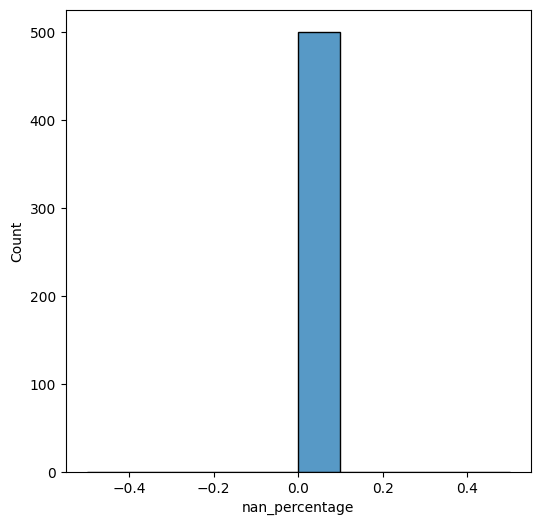

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns 

plt.figure(figsize=(6,6))
sns.histplot(df['nan_percentage'], bins=10)
plt.show()